# Data Challege: Software Price  
## Mihye Choi, Insight Data Science Fellow 
## July, 2nd, 2020



# Executive Summary

The goal of this project is to evaluate whether a test in increasing a price is successful or not. Based on the conversion data, the following conclusion can be drawn. 

1. The company should sell its software for high price (59.00) than low price(39.00). Price increase is a major success. The increased price (59.00) brought around 20% more revenue compared to the original price. 
2. The following actions may help improve customer conversion.
    - Source: maximize friend referral source channel. Brainstorm ideas on improving converstion rate for direct traffic and goole/fb ads.
    - Device: Not impactful
    - Operative system: Get more traffic from Apple OS or increase spend for Apple conversions. 
    - City: focus on NYC traffic if cost of ads/seo make sense. If the company needs to focus on other locations, Houston, Chicago, LA are good next options. Unconvetional options to consider include San Antonio, Jacksonville, and OKC.


BONUS: I additionally created Logistic Regression model to predict customer's conversion at the last part of this challenge

# Backgroud

Optimizing price is important for company revenue and future growth. Using data from the pricing test (39 USD vs. 59 USD), I examine which of the price would bring more revenue to company XYZ. Also, I exmaine patterns in the data and built a model to predict customer conversion to provide a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. Both the exploratory data analysis and a predictive model will provide useful recommendations for changes that the product and marketing team can make to improve conversion rates.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy
import statsmodels.api as sm

# Data Overview and Cleaning:

Below is a sample of the data showing the features including user ID (the Id of the user), timestamp (the date and time when the user hit for the first time company XYZ's webpage), source (from ads-["google", "facebook", "bing", "yahoo", "other"], from seo - ["google", "facebook", "bing", "yahoo", "other"], or from friend_referral-user coming from a referral link of another user, direct_traffic-user coming by directly typing the address of the site on the browser), device (user device, mobile or web), user operative_system ("windows", "mac" for web, and "android", "iOS" for mobile), test condition (1 -> higher price, 0 -> lower price), price (39 vs. 59), city (user location), and conversion (whether the user converted or not). 

First, the two different data files were merged based on user ID and initial exploratory data analysis was implemented. The initial exploratory data analysis showed that there were typos in operative system (e.g.,wnddows to window) and errors in price (e.g., other values rather than 39 or 59). The typos are corrected but errors and missing data were removed from the dataset.

#### Data Overview 

In [2]:
test_results = pd.read_csv('test_results.txt', delimiter=',')
user_table = pd.read_csv('user_table.txt', delimiter=',')
# Merge the two tables into one
all = test_results.join(user_table.set_index('user_id'), on='user_id') #inner join
cl_all= all.drop(all.columns[[0]], axis=1)
print(cl_all.head(5))

   user_id            timestamp          source  device operative_system  \
0   604839  2015-05-08 03:38:34    ads_facebook  mobile              iOS   
1   624057  2015-05-10 21:08:46      seo-google  mobile          android   
2   317970  2015-04-04 15:01:23        ads-bing  mobile          android   
3   685636  2015-05-07 07:26:01  direct_traffic  mobile              iOS   
4   820854  2015-05-24 11:04:40    ads_facebook     web              mac   

   test  price  converted          city country    lat   long  
0     0   39.0          0       Buffalo     USA  42.89 -78.86  
1     0   39.0          0     Lakeville     USA  44.68 -93.24  
2     0   39.0          0         Parma     USA  41.38 -81.73  
3     1   59.0          0  Fayetteville     USA  35.07 -78.90  
4     0   39.0          0       Fishers     USA  39.95 -86.02  


#### Data Cleaning

In [3]:
# Set proper price range
cl_all = cl_all[cl_all.price < 60]

# Correct typos
cl_all = cl_all.replace('wnddows', 'windows')
cl_all = cl_all.replace('apple', 'mac')
cl_all = cl_all.replace('i0S', 'iOS')
cl_all = cl_all.replace('anroid', 'android')
# Check missing data
cl_all = cl_all.dropna()
#operating_check = cl_all.operative_system.value_counts()/len(cl_all)
#source = cl_all.source.value_counts()/len(cl_all)

# Match test and price values
testprice_nomatch1 = cl_all[(cl_all['test'] == 1) & (cl_all['price']== 39)].index
cl_all.drop(testprice_nomatch1, inplace=True)
testprice_nomatch2 = cl_all[(cl_all['test'] == 0) & (cl_all['price']== 59)].index
cl_all.drop(testprice_nomatch2, inplace=True)
print(cl_all.head(5))

   user_id            timestamp          source  device operative_system  \
0   604839  2015-05-08 03:38:34    ads_facebook  mobile              iOS   
1   624057  2015-05-10 21:08:46      seo-google  mobile          android   
2   317970  2015-04-04 15:01:23        ads-bing  mobile          android   
3   685636  2015-05-07 07:26:01  direct_traffic  mobile              iOS   
4   820854  2015-05-24 11:04:40    ads_facebook     web              mac   

   test  price  converted          city country    lat   long  
0     0   39.0          0       Buffalo     USA  42.89 -78.86  
1     0   39.0          0     Lakeville     USA  44.68 -93.24  
2     0   39.0          0         Parma     USA  41.38 -81.73  
3     1   59.0          0  Fayetteville     USA  35.07 -78.90  
4     0   39.0          0       Fishers     USA  39.95 -86.02  


# Exploratory Data Analysis

In [4]:
pd.DataFrame.describe(cl_all) # Descriptive Analysis 

,user_id,test,price,converted,lat,long
count,254534.000000,254534.000000,254534.000000,254534.000000,254534.000000,254534.000000
mean,499156.826950,0.358730,46.174601,0.018701,37.107995,-93.982034
std,288473.070843,0.479629,9.592574,0.135467,5.210622,18.056394
min,3.000000,0.000000,39.000000,0.000000,19.700000,-157.800000
25%,249527.750000,0.000000,39.000000,0.000000,33.660000,-112.200000
50%,498796.500000,0.000000,39.000000,0.000000,37.720000,-88.930000
75%,748685.250000,1.000000,59.000000,0.000000,40.700000,-79.040000
max,999999.000000,1.000000,59.000000,1.000000,61.180000,30.310000


In [5]:
cl_all.groupby(cl_all.converted).mean() 

,user_id,test,price,lat,long
converted,,,,,
0,499112.567033,0.359701,46.194023,37.110609,-93.979790
1,501479.301050,0.307773,45.155462,36.970849,-94.099809


#### Conversion rate with 39 vs 59 USD price options 

Text(0.5, 0, 'price')

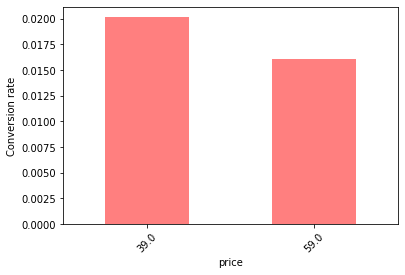

In [6]:
ax = cl_all.groupby("price")["converted"].mean().plot(kind="bar", color = "red", alpha = 0.5)
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel("Conversion rate") 
ax.set_xlabel("price")

In [7]:
print(pd.crosstab(cl_all.converted, cl_all.price)) 
print(pd.crosstab(index=cl_all.price, columns= cl_all.converted, normalize='index'))

expected_rev_39 = 39 * 0.020187 # expected revenue per customer with 39$ price option (see the table below)
expected_rev_59 = 59 * 0.016044 # expected revenue per customer with 59$ price option
prompt1= 'Expected revenue per customer is with price $36 option is ' #78 cents
prompt2= 'Expected revenue per customer is with price $59 option is ' #94 cents
print(prompt1 + str(expected_rev_39))
print(prompt2 + str(expected_rev_59))

growth = (expected_rev_59-expected_rev_39)/expected_rev_39 # revenue growth between low and high
prompt3= 'Expected revenue growth percentage with price $59 option is '
print(prompt3 + str(growth))

price        39.0   59.0
converted               
0          159930  89844
1            3295   1465
converted         0         1
price                        
39.0       0.979813  0.020187
59.0       0.983956  0.016044
Expected revenue per customer is with price $36 option is 0.787293
Expected revenue per customer is with price $59 option is 0.946596
Expected revenue growth percentage with price $59 option is 0.20234271103642476


I looked how the product price affected coversion first. Between the two prices that were compared, 39 and 59, there are more visitors who have been exposed to the original price (39 USD) than the new price and higher conversion rate in the 39 price option. But it is important to think the conversion rate in relation to its expected revenue. Thus, I calculated expected revenue per customer and compared it between the 39 USD and 59 USD price groups. 

The new price group (59.00) resulted in 25 percent less conversion but, due to the ~50 percent increase in price, comes out to revenue increase of ~20 percent. This result showed that even though higher prices decreases conversion,  the new price of $59 seems to be better option than the current price for company XYZ because it will create more revenue. 

#### Check other factors that can affect customer conversion

direct_traffic     0.191043
ads-google         0.187511
ads_facebook       0.168088
ads_other          0.094455
seo-google         0.072835
ads-bing           0.071951
seo_facebook       0.066789
friend_referral    0.065469
seo-other          0.029336
ads-yahoo          0.023961
seo-yahoo          0.021695
seo-bing           0.006867
Name: source, dtype: float64


Text(0.5, 0, 'Source')

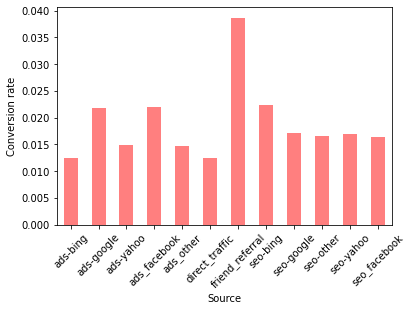

In [8]:
# Check Sources 
print(cl_all.source.value_counts()/len(cl_all))
#cl_all.groupby(cl_all.source).mean()
ax = cl_all.groupby("source")["converted"].mean().plot(kind="bar", color = "red", alpha = 0.5)
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel("Conversion rate") 
ax.set_xlabel("Source")

Direct traffic, ads from gogole, facebooks are effective while channels from yahoo, bing are not effective to attract more visitors to the website. In terms of conversion rate, sources are generally comparable except for friend referral which is superior. 

mobile    0.575188
web       0.424812
Name: device, dtype: float64


Text(0.5, 0, 'device')

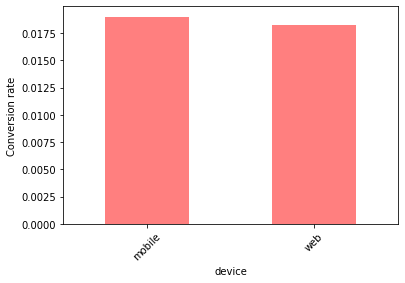

In [9]:
print(cl_all.device.value_counts()/len(cl_all))
cl_all.groupby(cl_all.device).mean()
ax = cl_all.groupby("device")["converted"].mean().plot(kind="bar", color = "red", alpha = 0.5)
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel("Conversion rate") 
ax.set_xlabel("device")


There are more visitors viewing the website through thier mobile device, but the types of device do not have an imact on conversion rate 

windows    0.340151
iOS        0.321768
android    0.253420
mac        0.084661
Name: operative_system, dtype: float64


Text(0.5, 0, 'Operative_system')

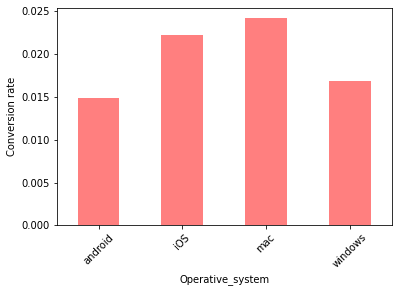

In [10]:
print(cl_all.operative_system.value_counts()/len(cl_all))
ax = cl_all.groupby("operative_system")["converted"].mean().plot(kind="bar", color = "red", alpha = 0.5)
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel("Conversion rate") 
ax.set_xlabel("Operative_system")

Here, apple users have a distinct advantage in conversion rate but most of the apple traffic is coming through the iOS. 

New York         0.001650
Houston          0.000444
Chicago          0.000365
San Antonio      0.000310
Los Angeles      0.000303
Austin           0.000240
San Jose         0.000216
Philadelphia     0.000181
Indianapolis     0.000169
Jacksonville     0.000165
Las Vegas        0.000157
Seattle          0.000145
Oklahoma City    0.000138
Oakland          0.000130
Charlotte        0.000126
Memphis          0.000122
Tucson           0.000118
Mesa             0.000110
Nashville        0.000110
Minneapolis      0.000106
dtype: float64


Text(0.5, 0, 'high revenue city')

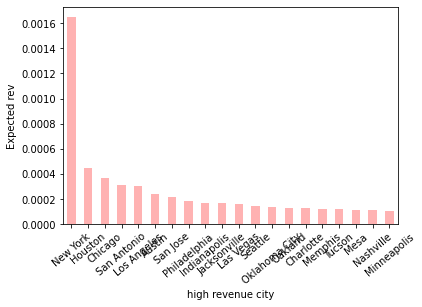

In [11]:
most_visited = cl_all.city.value_counts()/len(cl_all)
#print(most_visited.head(20))
con_cities = cl_all.groupby("city")["converted"].mean() # conversion rate in each city
#bucket cities in 4 - high visit/high conv, high visit/low conv, low visit/high conv, low visit/low conv
rev_cities = most_visited * con_cities # focus high/high
top20_rev = rev_cities.sort_values(ascending=False).head(20)
print(top20_rev)

#top20=high_con_cities.sort_values(ascending=False).head(20) 
#print(top20)
ax = top20_rev.plot(kind="bar", color = "red", alpha = 0.3)
ax.tick_params(axis='x', rotation=40)
ax.set_ylabel("Expected rev") 
ax.set_xlabel("high revenue city")

There are nearly a thousand of cities in the dataset. So I focused on those that have significant revenue impact which I created a proxy for, which I defined as the proportion of total visits attributed to each city * conversion rate for each city. With this metric, we can see NYC as the highest impact city by far. 

In [12]:
pd.crosstab(index= cl_all.converted, columns= cl_all.source, normalize='index' ) 

source,ads-bing,ads-google,ads-yahoo,ads_facebook,ads_other,direct_traffic,friend_referral,seo-bing,seo-google,seo-other,seo-yahoo,seo_facebook
converted,,,,,,,,,,,,
0,0.072405,0.186905,0.024054,0.167535,0.094842,0.192254,0.064134,0.006842,0.072950,0.029403,0.021732,0.066945
1,0.048109,0.219328,0.019118,0.197059,0.074160,0.127521,0.135504,0.008193,0.066807,0.025840,0.019748,0.058613


In [13]:
pd.crosstab(index= cl_all.converted, columns= cl_all.device, normalize='index') 

device,mobile,web
converted,,
0,0.575012,0.424988
1,0.584454,0.415546


In [14]:
pd.crosstab(index= cl_all.converted, columns= cl_all.operative_system, normalize='index') 

operative_system,android,iOS,mac,windows
converted,,,,
0,0.254414,0.320598,0.084188,0.340800
1,0.201261,0.383193,0.109454,0.306092


## Takeaways from the EDA:
### Converted customer on average are more likely to:
    1. Receive friend referral.
    2. Use mobile or web similarly. 
    3. Have Apple device (mac < iOS)
    4. Live in NYC. 

### Conversion Model with Logistic Regression

I created a logistic regression to predict customer conversion (which is a separate question from what I tried to see in the first section). This is a simple model that uses a logistic function to model a binary dependent variable, for example, converted (1) or not (0). The followings provide each step for the modeling. 

In [15]:
# Reorganizing features into a new dataframe
cl_all['newcity'] = np.where(cl_all.city == 'New York', 1, 0) # The city column now has binary variables, NY(1) OR NOT(0) 
final = cl_all[['source', 'device','operative_system','price','newcity','converted']]
final = pd.get_dummies(data=final, columns=['source', 'device','operative_system','price'])
final # data set for modeling

,newcity,converted,source_ads-bing,source_ads-google,source_ads-yahoo,source_ads_facebook,source_ads_other,source_direct_traffic,source_friend_referral,source_seo-bing,...,source_seo-yahoo,source_seo_facebook,device_mobile,device_web,operative_system_android,operative_system_iOS,operative_system_mac,operative_system_windows,price_39.0,price_59.0
0,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,1
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316794,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
316796,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,1,0
316797,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
316798,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,1,0,0,0,1,0


#### Imblance data
The dataset is imbalanced. Thus, I first downsampled the majority class (customers with no conversion) in my training data set before model training. Downsampling is to increase model performance by decreasing the size of the majority class in the dataset so that the data set can be more balanced.

In [83]:
from sklearn.utils import resample
# Create train and test sets 
split = np.random.rand(len(final)) < 0.95
train = final[split]
test = final[~split]
#print(train)

# Separate majority and minority classes
train_majority = train[train.converted==0]
train_minority = train[train.converted==1]
print(train_majority.converted.value_counts())
print(train_minority.converted.value_counts())

# Downsample majority class
train_majority_downsampled = resample(train_majority, replace=False, n_samples=len(train_minority)*2, random_state=123)
train_downsampled = pd.concat([train_majority_downsampled, train_minority])
train_downsampled.converted.value_counts()

0    237234
Name: converted, dtype: int64
1    4521
Name: converted, dtype: int64


0    9042
1    4521
Name: converted, dtype: int64

#### X (features) and Y (dependent variable, outcome) creation

In [84]:
# Y created
train_labels = np.array(train['converted'])
train_labels
train_downsampled_labels = np.array(train_downsampled['converted'])
test_labels = np.array(test['converted'])

# Remove the labels from the features - axis 1 is columns
train = train.drop('converted', axis = 1) # X
train
train_downsampled= train_downsampled.drop('converted', axis = 1)
test = test.drop('converted', axis = 1)
# Saving feature names for later use
train_colnames = list(train.columns)
train_downsampled_colnames = list(train_downsampled.columns)
test_colnames = list(test.columns)
# X created
train_features = np.array(train)
train_downsampled_features = np.array(train_downsampled)
test_features = np.array(test)

#### Model creation with full features 

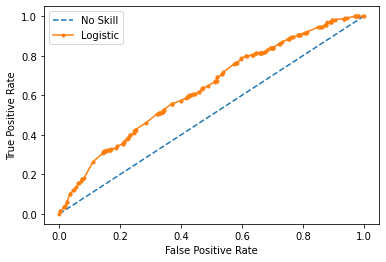

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     12540
           1       0.05      0.10      0.07       239

    accuracy                           0.95     12779
   macro avg       0.52      0.53      0.52     12779
weighted avg       0.97      0.95      0.96     12779



In [99]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot

# Create the conversion regression model with full features 
logreg = LogisticRegression(solver = 'liblinear')
logreg.fit(train_downsampled_features, train_downsampled_labels) 
y_predict = logreg.predict(test_features) 
lr_probs = logreg.predict_proba(test_features)
lr_probs = lr_probs[:, 1]

# calculate roc curves
fpr, tpr, thresholds = roc_curve(test_labels, lr_probs)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

# Evaluate model performance 
from sklearn import metrics
confusion_m = metrics.confusion_matrix(test_labels, y_predict)
confusion_m

from sklearn.metrics import classification_report
print(classification_report(test_labels, y_predict))

#### Modeling: Feature Engineering using RFE 
But the model above has too many features so this step is to reduce the number of features. 

One of essencial parts in modeling is to select appropriate features so that a model has a simple and good accuracy. Here, I used recursive feature elimination (RFE) for feature selection. This is an approach for eliminating features from a training dataset until the desired number of features remains. Features are ranked by the model’s coefficients.

In [139]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
model = LogisticRegression(solver = 'liblinear')
rfe = RFE(model, 5)
fit = rfe.fit(train_downsampled_features, train_downsampled_labels)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 5
Selected Features: [False False  True False  True False False  True False False False False
 False False False  True False False  True False False]
Feature Ranking: [17  4  1  5  1  6  2  1  7 14 15 13 16  8  9  1 11 10  1 12  3]


In [140]:
# Create the conversion regression model with partial 10 features 
new_cols=['source_ads-bing','source_ads-google','source_ads_facebook','source_ads_other','source_direct_traffic','source_friend_referral','operative_system_android','operative_system_windows','price_59.0'] 
X_train=train_downsampled[new_cols]
X_train = np.array(X_train)
X_test=test[new_cols]
X_test= np.array(X_test)

logreg = LogisticRegression()
logreg.fit(X_train, train_downsampled_labels) 
y_predict2 = logreg.predict(X_test) 

# Evaluate model performance 
from sklearn import metrics
confusion_m = metrics.confusion_matrix(test_labels, y_predict2)
confusion_m

from sklearn.metrics import classification_report
print(classification_report(test_labels, y_predict2))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     12540
           1       0.05      0.10      0.07       239

    accuracy                           0.95     12779
   macro avg       0.52      0.53      0.52     12779
weighted avg       0.97      0.95      0.96     12779



In [136]:
# model summary 
logit_model=sm.Logit(train_downsampled_labels,X_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.624590
         Iterations 5
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.019     
Dependent Variable: y                AIC:              16960.6239
Date:               2021-01-04 21:48 BIC:              17028.2598
No. Observations:   13563            Log-Likelihood:   -8471.3   
Df Model:           8                LL-Null:          -8633.0   
Df Residuals:       13554            LLR p-value:      4.1493e-65
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1       -0.6019     0.0818    -7.3591   0.0000   -0.7622   -0.4416
x2       -0.1231     0.0449    -2.7416   0.0061   -0.2111 

#### Summary and problem with modeling

The model with 10 features still did not predict 'conversion' well. Precision to class 1 (conversion rate) is close to 0 meaning that (both) models do not have an ability to correctly classify the categories. 

Why?
One of the reasons can be strongly related with features and sampling procedure. When I downsampled the majority class (data with no conversion), the patterns of data that we saw in EDA section could have disappeared. One way to overcome this problem may be to increase the minority class (data with conversion) by duplicating data. This approach is safer in that it will keep the patterns of conversion data shown in EDA.